In [1]:
!pip install -q langchain
!pip install -q torch
!pip install -q transformers
!pip install -q sentence-transformers
!pip install -q datasets
!pip install -q faiss-cpu
!pip install PyPDF2
!pip install accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 807.5/807.5 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.9/256.9 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.6/66.6 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.5/138.5 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.5/156.5 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 36.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━

In [2]:
!pip install -q -U segmentation-models-pytorch


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 27.5 MB/s eta 0:00:00


In [3]:
!pip install openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.4/227.4 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.8/77.8 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.5 MB/s eta 0:00:00


# Loading Necessary Libraries

In [27]:
from langchain.document_loaders import HuggingFaceDatasetLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.prompts import PromptTemplate

from langchain.vectorstores import FAISS
from transformers import AutoTokenizer, AutoModelForQuestionAnswering
from transformers import AutoTokenizer, pipeline
from langchain import HuggingFacePipeline
import transformers
from langchain.chains import RetrievalQA
import PyPDF2
import os
import re
import uuid
from skimage import io
import argparse
import inspect
from langchain.agents.initialize import initialize_agent
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.chat_models import ChatOpenAI
from langchain.agents.tools import Tool
from langchain.chains.conversation.memory import ConversationBufferMemory
import numpy as np
from transformers import BlipProcessor, BlipForConditionalGeneration
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as T
import cv2
import torch

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Loading model for Retrieval Augmentation Generation (RAG)

In [7]:
# Define the path to the pre-trained model you want to use
modelPath = "sentence-transformers/all-MiniLM-l6-v2"

# Create a dictionary with model configuration options, specifying to use the CPU for computations
model_kwargs = {'device':'cpu'}

# Create a dictionary with encoding options, specifically setting 'normalize_embeddings' to False
encode_kwargs = {'normalize_embeddings': False}

# Initialize an instance of HuggingFaceEmbeddings with the specified parameters
embeddings = HuggingFaceEmbeddings(
    model_name=modelPath,     # Provide the pre-trained model's path
    model_kwargs=model_kwargs, # Pass the model configuration options
    encode_kwargs=encode_kwargs # Pass the encoding options
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

# Calculating percentage of each class in the predicted image mask

In [8]:
def calculate_class_percentage(predicted_mask):
    class_names = ['urban_land', 'agriculture_land', 'rangeland', 'forest_land', 'water', 'barren_land', 'unknown']
    num_classes = len(class_names)

    class_percentages = {}

    for label, class_name in enumerate(class_names):
        class_pixels = np.sum(predicted_mask == label)
        class_percentage = (class_pixels / predicted_mask.size) * 100
        class_percentages[class_name] = class_percentage

    return class_percentages

# Loading LLM

In [26]:
import os
openai_api_key = '' #Your Openai_api_key

os.environ['OPENAI_API_KEY'] = openai_api_key

In [12]:
llm = ChatOpenAI(model_name='gpt-3.5-turbo')

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The class `langchain_community.chat_models.openai.ChatOpenAI` was deprecated in langchain-community 0.0.10 and will be removed in 0.2.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import ChatOpenAI`.
  warn_deprecated(


# Defining Prompt Template

In [15]:

prompt_template = """Use the following pieces of context to answer the question at the end.
If you don't know the answer, just say that you don't know, don't try to make up an answer. \
Give the answer in a good way. and don't just print the values of the land use classes.\
just give the value  specific to the user query.\
Also always give the detail of the image that what image shows.

Context: {context}

Question: {question}
Answer:


"""
PROMPT = PromptTemplate(
    template=prompt_template, input_variables=["context","question"]
)

### Creating a chatbot that takes image and question from the user and then gives linguistic ensights by taking predictions from the model as well as the image context

In [32]:

def Chatbot_Landuse(image_path, question, PROMPT, llm, embeddings, text_splitter):
  device = torch.device("cpu")
  resnet34_deeplabv3=torch.load("/content/drive/MyDrive/Data/Model/best_model_resnet34_deeplabv3.pth", map_location=torch.device('cpu'))
  transform = T.Compose([
    T.ToTensor(),
    T.Resize((1024, 1024)),
  ])
  img = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
  input_tensor = transform(img)
  input_batch = input_tensor.unsqueeze(0).to(device)
  with torch.no_grad():
    output = resnet34_deeplabv3(input_batch).squeeze()

  _, predicted_labels = torch.max(output, 0)
  predicted_mask = predicted_labels.squeeze().cpu().numpy()
  label_map_colors = {0: [0, 255, 255],
     1: [255, 255, 0],
     2: [255, 0, 255],
     3: [0, 255, 0],
     4: [0, 0, 255],
     5: [255, 255, 255],
     6: [0, 0, 0]}
  colored_mask = np.zeros((predicted_mask.shape[0], predicted_mask.shape[1], 3), dtype=np.uint8)
  for label, color in label_map_colors.items():
    colored_mask[predicted_mask == label] = color

  plt.subplot(1, 2, 1)
  plt.imshow(img)
  plt.axis('off')

  plt.subplot(1, 2, 2)
  plt.imshow(colored_mask)
  plt.axis('off')

  plt.show()
  model_answers=calculate_class_percentage(predicted_mask)
  model_id = "Salesforce/blip-image-captioning-base"
  model = BlipForConditionalGeneration.from_pretrained(model_id)
  processor = BlipProcessor.from_pretrained(model_id)
  image = Image.open(image_path).convert('RGB')
  inputs = processor(image, return_tensors="pt")
  out = model.generate(**inputs)
  image_context=processor.decode(out[0], skip_special_tokens=True)
  user_answers=[]
  user_answers.append(str(model_answers))
  user_answers.append(str(image_context))
  user_answers = text_splitter.create_documents(user_answers)
  db = FAISS.from_documents(user_answers, embeddings)
  retriever = db.as_retriever(search_kwargs={"k": 3})

  chain_type_kwargs = {"prompt": PROMPT}
  qa = RetrievalQA.from_chain_type(
      llm=llm,
      chain_type="stuff",
      retriever=retriever,
      chain_type_kwargs=chain_type_kwargs,
  )

  result = qa({'query': question})
  return result["result"]


In [33]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=150)


# Defining User input and question

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


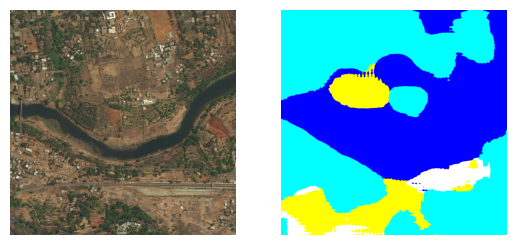

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1178: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


CPU times: user 29.6 s, sys: 385 ms, total: 30 s
Wall time: 34.7 s


'This image does not show any crop land. It mainly consists of urban land, water bodies (river), and some barren land.'

In [50]:
%%time
image_path="/content/drive/MyDrive/Data/test/393418_sat.jpg"
question="Does it show any crop land in the image?"
PROMPT=PROMPT
llm=llm
embeddings=embeddings

Chatbot_Landuse(image_path, question, PROMPT, llm, embeddings, text_splitter)